[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/5_nb_supervised_learning.ipynb) 


# Chapter 5 - Algorithms for supervised learning 
The fifths chapter of the course introduces two popular algorithms for supervised learning, the logistic regression model and classification and regression trees (CART). 

The outline of the tutorial is as follows:
- Logistic regression
  - The logistic function
  - Maximum likelihood estimation
  - Libraries for logistic regression
- Decision trees


# Logistic regression
We learned from the lecture that the logistic model is the goto model for regression problems with a discrete target variable. Let us revisit this model and its underlying functionality. Let's start with revisiting the logistic function.

## The logistic function

Text(0.5, 0, 'z')

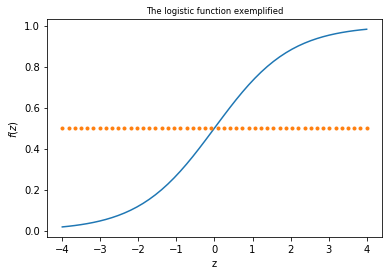

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# we implement the logistic function as a custom function
def my_log (z):
    return 1/(1+np.exp(-z))


# create some data for plotting
z = np.linspace(-4, 4)

fz = my_log(z)
plt.title("The logistic function exemplified", fontsize='small')
plt.plot(z, fz);
plt.plot(z, np.repeat(0.5, len(z)), ".");  #  just for fun, add a horizontal line to highlight 0.5
plt.ylabel("$f(z)$")
plt.xlabel("z")

It is a good exercise to check how changes the above implementation change the plot. For example, you could add a constant multiplier and calculate $e^{(\alpha z)} $ instead of $e^{(z)}$, and check how the shape of the function changes with $\alpha$. 


## Maximum likelihood estimation
The lecture made the point that logistic regression is a linear classifier. Let's make sure we fully understand that that means. First, we need some data to play with. For start, we will create synthetic data for a binary classification problem in two dimensions. 

In [ ]:
from sklearn.datasets import make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, n_samples=500)
print("Shape of X {}".format(X.shape))  # it's always useful to remind oneself of the dimensions of a data set
print("Shape of y {}".format(y.shape))

Shape of X (500, 2)
Shape of y (500,)


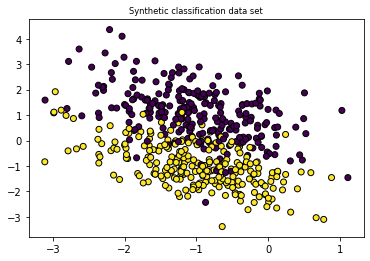

In [ ]:
# Here is the code for the plot
plt.title("Synthetic classification data set", fontsize='small')
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, edgecolor='k');

The lecture made the point that estimating a logistic regression model involves minimizing the negative log-likelihood function. Some students find that part tough, probably because of the formalism. Let's try to demystify the model by implementing it from scratch.

Recall that the model the probability of observing a certain state of our target variable $y$ by means of the logistic function.

$$ p \left( y=1|x \right) = \frac{1}{1+e^{-z}}, \text{  and  }  p \left( y=0|x \right) = 1- p \left( y=1|x \right) $$

where $z$ is defined as a linear, additive function of the features: $z=\beta_0+\beta x$. Assuming our data fulfills the IID assumption, we can write down the log-likelihood function 
$$ \mathcal{L} = \sum^{n}_{i=1} \left[ y_i \log \left(p \left( y=1|x \right) \right) + \left(1-y_i\right) \log \left(1-p \left( y=1|x \right) \right)\right] $$,

which we minimize over our $n$ data points $\left( y_i, x_i \right)$. Specifically, we will use *gradient descent* for the minimization. That is clearly not the most sophisticated solver, far better and faster options exist, but helps to keep the demo simple.

# Logistic Regression from scratch

We can create a logistic regression function from scratched based on the [medium article here](https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac)

We will be using the data created from tutorial #3 as a data set for this section.

In [ ]:
class1_x = np.random.normal(loc=1, scale=1, size=1000)
class1_y = np.random.normal(loc=1, scale=1, size=1000)

class2_x = np.random.normal(loc=4, scale=1, size=1000)
class2_y = np.random.normal(loc=4, scale=1, size=1000)

lab1 = np.repeat(0, 1000)
lab2 = np.repeat(1, 1000)

class1 = np.vstack((class1_x, class1_y)).T
class2 = np.vstack((class2_x, class2_y)).T

data = np.vstack((class1, class2))
labels = np.concatenate((lab1, lab2))

print(data[:5,:])

[[ 1.5230176   0.13077605]
 [ 1.20514159 -0.14598907]
 [ 1.1219751   1.7197403 ]
 [ 3.01822051  1.66287977]
 [ 0.74337131  1.10853273]]


In [ ]:
print(labels[:5])

[0 0 0 0 0]


We first need a function which will output numbers between 0 and 1. As mentioned, sigmoid is a popular function which meets this criteria so we can use it here.

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

We also need a loss function whose gradient we will determine which way to adjust parameters.

In [ ]:
def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [ ]:
def get_logit_weights(X, y, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
    if fit_intercept:
      intercept = np.ones((X.shape[0], 1))
      X = np.concatenate((intercept, X), axis=1)
        
    weights = np.zeros(X.shape[1]) # initialize weights
    
    for i in range(num_iter):
        z = np.dot(X, weights)
        h = sigmoid(z)
        gradient = np.dot(X.T, (h - y)) / y.size
        weights -= lr * gradient
            
    if(verbose == True and i % 10000 == 0): # checks loss at each iteration
        z = np.dot(X, weights)
        h = sigmoid(z)
        loss_val = loss(h, y)
        print(f'loss: {loss_val} \t')
    return weights

Lastly, we will want our function to end up predicting probabilities for new data based on the old function's weights. 

In [ ]:
def predict_prob(X, weights, fit_intercept=True):
    if fit_intercept:
        intercept = np.ones((X.shape[0], 1))
        X = np.concatenate((intercept, X), axis=1)
        return sigmoid(np.dot(X, weights))

In [ ]:
def predict(X, weights, fit_intercept=True, threshold=0.5):
    predictions = predict_prob(X, weights, fit_intercept=fit_intercept) >= threshold
    predictions = np.where(predictions==False, 0, predictions)
    predictions = np.where(predictions==True, 1, predictions)
    return predictions

Now we can train our model on the data that we have generated to get the intercept (first number in the weights array) and coefficients (the subsequent numbers in the array). 

In [ ]:
weights = get_logit_weights(data, labels)

In [ ]:
print(weights)

[-10.68659487   2.09775291   2.08959301]


Now we can get the probabilities of class 1 for each observation. We also defined a function which evaluates the decision of 0 or 1 based on a threshold value that we can adjust. We can then compare this predicted value to the true labels and calculate the mean error or mean accuracy.

In [ ]:
results = predict_prob(data, weights, fit_intercept=True)

print(results[:5])

[7.32428925e-04 2.10974278e-04 8.66800333e-03 2.93100686e-01
 1.10059481e-03]


In [ ]:
results = predict(data, weights, fit_intercept=True, threshold=0.5)

print(results[:5])

[0 0 0 0 0]


In [ ]:
accuracy = labels == results

mean_accuracy = accuracy.sum() / len(accuracy)

mean_accuracy

0.983

Logisitic regression generates a linear decision boundary. We can also plot this boundary using the intercept found in `w[0]` and the two coefficients found in `w[1]` and `w[2]`.

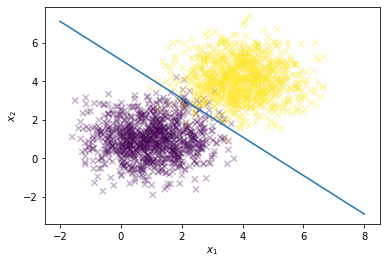

In [ ]:
w = weights[1:]
xx = np.linspace(-2,8)

a = -w[0] / w[1]
b = -weights[0] / w[1]

yy = a * xx + b

fig = plt.figure()
plt.scatter(data[:,0], data[:,1], c=labels, alpha=.3, marker='x')
plt.plot(xx,yy);
plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

## Libraries for logistic regression

Now that we know that estimating a logistic regression model using the maximum likelihood approach is not some sort of dark magic, we might feel more comfortable with using libraries that hide all the details. In fact, you have already seen one such library in action in [Tutorial 3](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/3_nb_predictive_analytics.ipynb). There, we used the `statsmodels` library to estimate a logit model. Let's revisit the corresponding codes. However, doing so for our toy data is pointless. Time for a real-world data set, and since we spent so much time on cleaning and preparing and understanding the HMEQ data in [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb), it would be a shame to not use it for demonstrating logistic regression on some real data. Remember that [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb) discusses that data set in detail, so simply go back to the previous tutorial is you need a refresher.

In [ ]:
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
# Load data from GitHub
data_url = 'https://raw.githubusercontent.com/Humboldt-WI/bads/master/data/hmeq_modeling.csv' 
df = pd.read_csv(data_url, index_col="index")

Let's take a quick look at the data to re-familiarize ourselves with the classification task.

In [ ]:
df.head(5)

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


In [ ]:
# Split into target and features
y = df.BAD.values.astype(int)
X = df.iloc[:,1:]

# We add a constant column to X. Think of this as the Python way to include an intercept in your model 
X = add_constant(X, prepend=True, has_constant='raise')
# Estimate logit model
logit_model = sm.Logit(y, X.astype(float), ) 
logit_model = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.405599
         Iterations 6


A nice feature of the `statsmodels` implementation is that you can easily produce a standard regression table. 

In [ ]:
logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5960
Model:                          Logit   Df Residuals:                     5942
Method:                           MLE   Df Model:                           17
Date:                Fri, 23 Oct 2020   Pseudo R-squ.:                  0.1883
Time:                        16:12:30   Log-Likelihood:                -2417.4
converged:                       True   LL-Null:                       -2978.2
Covariance Type:            nonrobust   LLR p-value:                7.822e-228
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.0454        nan        nan        nan         nan         nan
LOAN                -0.1491      0.042     -3.586      0.000      -0.231      -0.068
MORTDUE             -0.1913      0.065     -2.953      0.003      -0.318      -0.064
VALUE                0.0706      0.069      1.027      0.304      -0.064       0.205
YOJ                 -0.0881      0.040     -2.190      0.029      -0.167      -0.009
CLAGE               -0.4613      0.042    -11.006      0.000      -0.543      -0.379
NINQ                 0.3301      0.030     11.060      0.000       0.272       0.389
CLNO                -0.1327      0.045     -2.938      0.003      -0.221      -0.044
DEBTINC              0.4228      0.043      9.868      0.000       0.339       0.507
DEROGzero           -1.0454        nan        nan        nan         nan         nan
REASON_HomeImp       0.2472      0.089      2.770      0.006       0.072       0.422
REASON_IsMissing     0.3667      0.174      2.110      0.035       0.026       0.707
JOB_Office          -0.6847        nan        nan        nan         nan         nan
JOB_Other           -0.0256        nan        nan        nan         nan         nan
JOB_ProfExe          0.0376        nan        nan        nan         nan         nan
JOB_Sales            1.1200      0.136      8.237      0.000       0.854       1.387
JOB_Self             0.6336      0.151      4.201      0.000       0.338       0.929
DELINQcat_1          1.2601      0.179      7.020      0.000       0.908       1.612
DELINQcat_1+         2.3296      0.138     16.849      0.000       2.059       2.601
====================================================================================
"""

Spend a little time on inspecting the table. The pseudo $R^2$ statistic suggests that the model explains only a moderate amount of the variability of the target variable. However, we find from the *LLR test* that the model as a whole is highly significant. Further, most features come out as significant,  two dummy variables for the job categories *prof. executive* and *other* and the feature VALUE being an exception. Remember the result of the analysis of feature correlation in [Tutorial 4](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/4_nb_data_preparation.ipynb)? The result for the VALUE feature is surely due to the high correlation of this feature with MORTDUE.    

In [ ]:
np.corrcoef(df.MORTDUE, df.VALUE)

array([[1.        , 0.82513958],
       [0.82513958, 1.        ]])

Reestimating the logit model after removing the feature MORTDUE would be a good exercise. After the modification, VALUE should come out as significant.

We could easily continue our discussion of the regression table to draw more conclusions about our data. However, this is not the point the focal tutorial. Instead, let's look at another implementation of logistic regression. The famous `scikit-learn` library is the goto library for machine learning in Python. We will use it intensively throughout the course. It also supplies an implementation of logistic regression. Let's see how to use that implementation      

In [ ]:
from sklearn.linear_model import LogisticRegression

sk_logit = LogisticRegression(penalty='none', fit_intercept=False)  # Recall that we already included a constant column in X. 
sk_logit.fit(X, y)                                                  # So we must set fit_intercept to False

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The sklearn implementation is geared toward predictive modeling. For example, there is no way to easily obtain fitting statistics or shed light on the significance of features. On the other hand, the class `LogisticRegression` supports many advanced features to maximize the predictive power of the logit model. The above output already hints at the many different parameters that you can configure. Have a look into the help if you'd like to learn more. We will cover important parameters like those associated with *regularization* in chapter 7 of BADS. One easy to appreciate advantage of `sklearn` over `statsmodels` when it comes to logistic regression is scalability. The sklearn implementation is faster and can cope with larger data sets.

Given the differences between our two logit models, the only way to compare them (for now) is by inspecting the estimated model coefficients.  

In [ ]:
# Create a dataframe for the comparison
# Note that we also need some conversions to ensure that the two coefficient arrays are compatible
pd.DataFrame({"statsmodels" :logit_model.params.to_numpy(), "sklearn": sk_logit.coef_[0]})
df_comparison

,statsmodels,sklearn
0,-1.045379,-1.045312
1,-0.149086,-0.149104
2,-0.191345,-0.191345
3,0.070593,0.070596
4,-0.088118,-0.088134
5,-0.461284,-0.461275
6,0.330069,0.330033
7,-0.132715,-0.132714
8,0.422777,0.422795
9,-1.045379,-1.045312


Conclusion: the two implementations of the logit model deliver similar results. That is nice but maybe not too exciting. The main take-away is that, when it comes to logistic regression, ask yourself whether you want to use the model for an explanatory or predictive purpose. Use the implementation within `statsmodels` in the former and `sklearn` in the latter case. 

# Decision Trees

Decision trees are useful and powerful algorithms for classifying and regressing data. It works on recursive partitioning which will be shown algorithmically in this notebook. Though most of the the time, Sci-Kit Learn can be used to implement this machine learning method simply, it is useful to take a look at the inner workings of these algorithms. The following parts will first introduce a decision tree from scratch, before demonstrating its coverage in `sklearn`. 

## Decision Tree From Scratch Using HMEQ Data

Firstly, we will go through a decision tree made from scratch. The following code is based on the material originally created by Sebastian Mantey for the Iris Dataset whose GitHub is here: https://github.com/SebastianMantey/Decision-Tree-from-Scratch. You can also search his video on YouTube. The code has been adapted to this course's format and fit to HMEQ Dataset.

Just in case you made changes to the data by running the above code, we first reload the data to a fixed and clear-defined starting point for our tree classifier. Recall that we defined the variable `data_url` above.

In [ ]:
df = pd.read_csv(data_url, header = 0, index_col = 0) # import file with header and index as first row and column respectively

df.head() #inspect data to make sure it looks correct

In [ ]:
X = df.drop(['BAD'], axis=1) #code the variables in the most standard way for your usage
y = df[['BAD']]

In [ ]:
print(type(X), type(y), X.shape, y.shape) # double check that types and dimensions are correct before proceeding

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'> (5960, 18) (5960, 1)


### Helper Functions for the Tree

Decision trees work by recursively partitioning data which means:

Many potential ways to split the data are calculated (eg. we are going to go through all unique values of each column and finding the midpoint between sequential values). For each potential split, we evaluate whether the target variable has more homogeneity in each leaf. This is done by calculating 'impurity' of the parent node and comparing it with the sum of the impurity of the child nodes. There are three major impurity functions: entropy, gini and misclassification. We will be using entropy in our example. The split which yields the lowest impurity is chosen and the process is repeated for the new nodes (this is recursion). 

The method of choosing the split which yields the lowest impurity is called the greedy search method. The following functions will help the decision tree implement greedy search tactics on the data. The algorithm stops either when purity in each node is reached or when it has reached a maximum depth (max amount of recursions we allow) specified in our function.

Many functions for the tree are not found in Python packages and it is cleaner to write them out first then put them together in our main algorithm. Each function below does a specific action which will be used in our final tree function at the end.

In [ ]:
def check_purity(y):
    
    'checks if a leaf node is perfectly pure, in other words, if the leaf node contains only one class'
    
    unique_classes = np.unique(y) #count number of classes in section of data

    if len(unique_classes) == 1: #check if the node is pure
        return True
    else:
        return False

In [ ]:
def classify_data(y):
    
    'classifies data according to the majority class of each leaf'
    
    unique_classes, counts_unique_classes = np.unique(y, return_counts=True)
    #returns classes and no. of obs per class

    index = counts_unique_classes.argmax() #index of class with most obs
    classification = unique_classes[index] #class chosen for classification which is class with most obs
    
    return classification

In [ ]:
def get_potential_splits(X):
    
    'first, takes every unique value of every feature in the feature space, then finds the midpoint between each value'
    
    potential_splits = {}
    _, n_columns = X.shape #don't need rows, we choose the column to split on
    # only need second value of .shape which is columns
    
    for column_index in range(n_columns):
        potential_splits[column_index] = [] 
        values = X[:, column_index] 
        unique_values = np.unique(values) #get all unique values in each column

        for index in range(len(unique_values)): #all unique feature values
            if index != 0: #skip first value, we need the difference between next values
                current_value = unique_values[index]
                previous_value = unique_values[index - 1] #find a value and the next smallest value
                potential_split = (current_value + previous_value) / 2 #find difference between the two as a potential split
                
                #consider all values which lie between two values as a potential split
                
                potential_splits[column_index].append(potential_split)
    
    return potential_splits

In [ ]:
def split_data(X, y, split_column, split_value):
    
    'splits data based on specific value, will yield both a split for the features X and target y'
    
    split_column_values = X[:, split_column]

    X_below = X[split_column_values <= split_value] #partitions data according to split values from previous functions
    X_above = X[split_column_values >  split_value]
    
    y_below = y[split_column_values <= split_value]
    y_above = y[split_column_values >  split_value]
    
    return X_below, X_above, y_below, y_above

In [ ]:
def calculate_entropy(y):
    
    'calculates entropy for each partition of data'
    
    _, counts = np.unique(y, return_counts=True) #we only need the counts of each class, _ is a placeholder

    probabilities = counts / counts.sum() #probability of each class
    entropy = sum(probabilities * -np.log2(probabilities)) #could replace with Gini impurity or misclassification
     
    return entropy

In [ ]:
def calculate_overall_entropy(y_below, y_above): 
    
    'calculates the total entropy after each split'
       
    n = len(y_below) + len(y_above)
    p_data_below = len(y_below) / n
    p_data_above = len(y_above) / n

    overall_entropy =  (p_data_below * calculate_entropy(y_below)
                      + p_data_above * calculate_entropy(y_above))
    
    return overall_entropy

In [ ]:
def determine_best_split(X, y, potential_splits):
    
    'selects which split lowered entropy the most'
    
    overall_entropy = 9999 #set arbitrarily high, the function will loop over and replace this with lower impurity values
    for column_index in potential_splits:
        for value in potential_splits[column_index]:
            X_below, X_above, y_below, y_above = split_data(X, y, split_column=column_index, split_value=value)
            current_overall_entropy = calculate_overall_entropy(y_below, y_above)
            
            #goes through each potential split and only updates if it lowers entropy

            if current_overall_entropy <= overall_entropy: 
                overall_entropy = current_overall_entropy #updates only if lower entropy split found, in the ned this is greedy search
                best_split_column = column_index
                best_split_value = value
    
    return best_split_column, best_split_value

### The Main Algorithm

The tree will now implement the helper functions and display the decision which yielded the best split if printed.

In [ ]:
def decision_tree_algorithm(X, y, counter=0, min_samples=2, max_depth=5): 
    
    # data preparation
    if counter == 0: # counter tells us how deep the tree is, this is before the tree is initiated
        global COLUMN_HEADERS
        COLUMN_HEADERS = X.columns
        X = X.values #change all to NumPy array for faster calculations
        y = y.values
    else:
        data = X #if we have started the tree, X should already be a NumPy array from the code above 
    
    # base cases
    if (check_purity(y)) or (len(X) < min_samples) or (counter == max_depth):
        classification = classify_data(y)
        
        return classification
    
    # recursive part
    else:    
        counter += 1 #tells us how deep the tree is

        # helper functions 
        potential_splits = get_potential_splits(X) #check for all possible splits
        best_split_column, best_split_value = determine_best_split(X, y, potential_splits) #select best split based on entropy
        X_below, X_above, y_below, y_above = split_data(X, y, best_split_column, best_split_value) #execute best split
        
        # code to explain decisions made by tree to users
        feature_name = COLUMN_HEADERS[best_split_column]
        question = "{} <= {}".format(feature_name, best_split_value) #initiate explanation of split
        sub_tree = {question: []}
        
        # pull answers from tree
        yes_answer = decision_tree_algorithm(X_below, y_below, counter, min_samples, max_depth)
        no_answer = decision_tree_algorithm(X_above, y_above, counter, min_samples, max_depth)
        
        # ensure explanation actually shows useful information
        if yes_answer == no_answer: #if decisions are the same, only display one
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)
        
        return sub_tree

### Grow First Tree

Test the tree and display the decisions with a shallow depth.

In [ ]:
tree = decision_tree_algorithm(X, y, max_depth=2)

#### Structure of the First Tree

In [ ]:
from pprint import pprint  # library for prettier print output

pprint(tree)

{'DEBTINC <= 0.13253751764464605': [False,
                                    {'DEBTINC <= 0.137471043429223': [True,
                                                                      False]}]}


In [ ]:
tree.values()

dict_values([[False, {'DEBTINC <= 0.137471043429223': [True, False]}]])

The first node in the tree asks the question:

DEBTINC <= 0.13253751764464605

If this is true, the tree will predict BAD as false.

If this is false, the tree will ask a second question:

DEBTINC <= 0.137471043429223

If true, the tree will predict BAD is true. If false, the tree will predict BAD is false.

#### Classification Example from First Tree

Let's take an example and see how the tree classifies it.

In [ ]:
example = df.iloc[2] #take a random observation
example

BAD                      True
LOAN                 -1.78905
MORTDUE              -1.65455
VALUE                -1.83928
YOJ                 -0.668103
CLAGE               -0.368769
NINQ               -0.0650545
CLNO                  -1.1893
DEBTINC              0.137456
DEROGzero                True
REASON_HomeImp              1
REASON_IsMissing            0
JOB_Office                  0
JOB_Other                   1
JOB_ProfExe                 0
JOB_Sales                   0
JOB_Self                    0
DELINQcat_1                 0
DELINQcat_1+                0
Name: 2, dtype: object

In [ ]:
def classify_example(example, tree):
    question = list(tree.keys())[0] #checks what is the next data split
    feature_name, comparison_operator, value = question.split() #splits question into elements

    # ask question
    if example[feature_name] <= float(value): # checks key element for split
        answer = tree[question][0] # selects yes answer
    else:
        answer = tree[question][1] # selects no answer

    # base case
    if not isinstance(answer, dict): # if answer is not a dictionary, we have reached a decision
        return answer # display prediction
    
    # recursive part
    else:
        residual_tree = answer # continue if another dictionary is reached
        return classify_example(example, residual_tree)

In [ ]:
classify_example(example, tree)

True

In [ ]:
y.iloc[2]

BAD    True
Name: 2, dtype: bool

The classification for this one instance above is correct, how well does this tree do for the rest of the data points?

#### Predictions and Accuracy from First Tree

In [ ]:
predictions = X.apply(classify_example, axis=1, args=(tree,))

In [ ]:
error = np.mean(np.vstack(predictions) == np.array(y))

error

0.851006711409396

The tree is able to classify a good proportion of the test set well even with only a depth of 2.

### Higher Depth in Tree

Test the tree and display the decisions with a higher depth to see if accuracy changed.

In [ ]:
tree_deep = decision_tree_algorithm(X, y, max_depth=5)

In [ ]:
predictions_deep = X.apply(classify_example, axis=1, args=(tree_deep,))

In [ ]:
error_deep = np.mean(np.vstack(predictions_deep) == np.array(y))

error_deep

0.8897651006711409

The performance of the tree is even better with this depth. However, as we continue to increase depth, there will come a point where the accuracy decreases as the tree internalizes noise from the data. This is called overfitting and weakens the tree's ability to classify unseen observations. Thus, the tree can be deepened only until the test set accuracy begins decreasing.

## Decision Trees with Sci-Kit Learn

As mentioned, the package Ski-Kit Learn has prebuilt functions which avoid coding most algorithms by scratch. Now armed with the knowledge of the inner workings of the decision tree, it should be easier to understand what this algorithm is trying to achieve.

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion="entropy", min_samples_split=2, max_depth=2) #keep tree at a low depth

dt_shallow = clf.fit(X, y)

In [ ]:
pred_dt_shallow = dt_shallow.predict(X)

In [ ]:
pred_dt_shallow[0:5]

array([ True,  True,  True,  True,  True])

In [ ]:
classify_correct_shallow = pred_dt_shallow == y.iloc[:,0]
accuracy_shallow = classify_correct_shallow.mean()


accuracy_shallow

0.851006711409396

[Text(167.4, 181.2, 'X[7] <= 0.133\nentropy = 0.721\nsamples = 5960\nvalue = [4771, 1189]'),
 Text(83.7, 108.72, 'X[17] <= 0.5\nentropy = 0.315\nsamples = 2341\nvalue = [2208, 133]'),
 Text(41.85, 36.23999999999998, 'entropy = 0.261\nsamples = 2215\nvalue = [2117, 98]'),
 Text(125.55000000000001, 36.23999999999998, 'entropy = 0.852\nsamples = 126\nvalue = [91, 35]'),
 Text(251.10000000000002, 108.72, 'X[7] <= 0.137\nentropy = 0.871\nsamples = 3619\nvalue = [2563, 1056]'),
 Text(209.25, 36.23999999999998, 'entropy = 0.959\nsamples = 1273\nvalue = [486, 787]'),
 Text(292.95, 36.23999999999998, 'entropy = 0.514\nsamples = 2346\nvalue = [2077, 269]')]

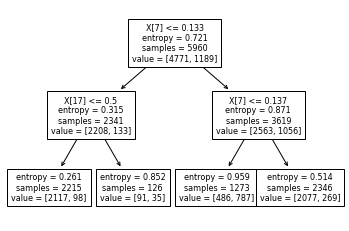

In [ ]:
tree.plot_tree(dt_shallow, fontsize=8)

### SK Learn Tree with No Limit on Depth

If we remove the maximum depth parameter, the algorithm will go as far as it can until all nodes are pure.

In [ ]:
clf = tree.DecisionTreeClassifier(criterion='entropy', min_samples_split=2)

dt_deep = clf.fit(X, y)

pred_dt_deep = dt_deep.predict(X)

In [ ]:
pred_dt_deep[0:5]

array([ True,  True,  True,  True, False])

In [ ]:
classify_correct_deep = pred_dt_deep == y.iloc[:,0]
accuracy_deep = classify_correct_deep.mean()

accuracy_deep

1.0

While this seems great at first glance, what is the problem here? What does this mean for new data that we encounter whose idiosyncracies may be slightly different than the data we used to train the model?